In [1]:
import os
from PIL import Image
import numpy as np
from keras.layers import Input, Convolution2D, merge, Dense, Dropout, Flatten, Conv2D, MaxPooling3D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import math
from skimage.io import imread
from matplotlib import pyplot as plt
import sklearn.feature_extraction
import sklearn.feature_selection as t
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
import scipy.ndimage.filters
import random

Using TensorFlow backend.


In [2]:
def PSNR(y_true, y_pred):
    return 10.0 * K.log(1 / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

In [3]:
def threecompare(in_im, out_im, pred_im):
    img1 = out_im*255
    img2 = in_im*255
    kernel = np.ones((3,3))*(-1)
    kernel[1,1] = 8
    new_im = channels2data(img2)
    h_im = np.zeros((img2.shape[2], img2.shape[0], img2.shape[1]))
    for i in range(img2.shape[2]):
        h = new_im[i]
        h = h.reshape(img2.shape[0], img2.shape[1])
        lap = scipy.ndimage.filters.convolve(h, kernel)
        laps = lap*100.0/np.amax(lap)
        h_im[i] = (h + laps/10)
    img3 = data2channels(h_im).astype('float32')
    img4 = pred_im*255
    ssim1 = ssim(img1, img1, data_range=img1.max() - img1.min(), multichannel=True)
    ssim2 = ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)
    ssim3 = ssim(img1, img3, data_range=img3.max() - img3.min(), multichannel=True)
    ssim4 = ssim(img1, img4, data_range=img4.max() - img4.min(), multichannel=True)
    label = 'SSIM: {:.2f}'
    print('Original image')
    print(label.format(ssim1))
    print('\n'+'Bicubic image')
    print(label.format(ssim2))
    print('\n'+'Bicubic with laplasian image')
    print(label.format(ssim3))
    print('\n'+'Produced image')
    print(label.format(ssim4))

In [4]:
def imload(d, mode, channels, img_rows, img_cols):
    directory = '../Картинки/'+d
    files = os.listdir(directory)
    flag = True
    i = 0
    while flag and i < len(files):
        if files[i] == '.DS_Store':
            del files[i]
            flag = False
        i+= 1
    num = 0
    for name in range(len(files)):
        im = Image.open(directory+'/'+ files[name]).convert('L')
        width, height = im.size
        num += (width//img_rows)*(height//img_cols)
    num = num*4
    x = np.zeros((num, img_rows, img_cols, channels))
    y = np.zeros((num, img_rows, img_cols, channels))
    num1 = np.zeros((num))
    num = 0
    for name in range(len(files)):
        I = Image.open(directory+'/'+ files[name]).convert('RGB')
        width1, height1 = I.size
        if (width1//img_rows > 1) and (height1//img_cols > 1):
            for i in range(width1//img_rows):
                for j in range(height1//img_cols):
                    im = I.crop((i*img_rows, j*img_cols, (i+1)*img_rows, (j+1)*img_cols))
                    width, height = im.size
                    for k in range(4):
                        im_ = im.rotate(90*k)
                        a = np.asarray(im_).astype('float32')
                        im1 = im_.resize((int(width/2), int(height/2)))
                        im1 = im1.resize((width, height), Image.BICUBIC)
                        a1 = np.asarray(im1).astype('float32')
                        a = a.reshape(img_rows, img_cols, channels)
                        a1 = a1.reshape(img_rows, img_cols, channels)
                        flag = True
                        while flag:
                            e = random.randint(0, len(num1)-1)
                            if num1[e] != 1:
                                flag = False
                        num1[e] = 1
                        x[e] = a1
                        y[e] = a
        elif width1//img_rows > 1:
            for i in range(width1//img_rows):
                im = I.crop((i*img_rows, 0, (i+1)*img_rows, img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        elif height1//img_cols > 1:
            for j in range(height1//img_cols):
                im = I.crop((0, j*img_cols, img_rows, (j+1)*img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        else:
            im = I.crop((0,0,img_rows, img_cols))
            width, height = im.size
            for k in range(4):
                im_ = im.rotate(90*k)
                a = np.asarray(im_).astype('float32')
                im1 = im_.resize((int(width/2), int(height/2)))
                im1 = im1.resize((width, height), Image.BICUBIC)
                a1 = np.asarray(im1).astype('float32')
                a = a.reshape(img_rows, img_cols, channels)
                a1 = a1.reshape(img_rows, img_cols, channels)
                flag = True
                while flag:
                    e = random.randint(0, len(num1)-1)
                    if num1[e] != 1:
                        flag = False
                num1[e] = 1
                x[num] = a1
                y[num] = a
                num += 1
    return x, y

In [5]:
def preprocess(x, y, channels, img_rows, img_cols):
    x /= 255
    y /= 255
    x = x.astype('float32')
    y = y.astype('float32')
    x = x.reshape(x.shape[0], img_rows, img_cols, channels)
    y = y.reshape(y.shape[0], img_rows, img_cols, channels)
    return x, y

In [6]:
def getim(im):
    im1 = Image.new('RGB', (im.shape[0],im.shape[1]))
    p = im1.load()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            helper = []
            for k in range(im.shape[2]):
                if int(im[i][j][k]) > 255:
                    helper.append(255)
                elif int(im[i][j][k]) < 0:
                    helper.append(0)
                else:
                    helper.append(int(im[i][j][k]))
            p[i,j] = tuple(helper)
    return im1

In [7]:
def channels2data(im):
    answer = np.zeros((im.shape[2], im.shape[0], im.shape[1]))
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for k in range(im.shape[2]):
                answer[k,i,j] = im[i,j,k]
    return answer

In [8]:
def data2channels(ar):
    answer = np.zeros((ar.shape[1], ar.shape[2], ar.shape[0]))
    for i in range(ar.shape[0]):
        for j in range(ar.shape[1]):
            for k in range(ar.shape[2]):
                answer[j,k,i] = ar[i,j,k]
    return answer

In [9]:
def results(x, y, p, img_rows, img_cols, f):
    PSNR_bicubic = 0
    PSNR_laplasian = 0
    PSNR_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        im2 = y[i]*255
        im3 = p[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        new_im = channels2data(im1)
        h_im = np.zeros((im1.shape[2], im1.shape[0], im1.shape[1]))
        for l in range(im1.shape[2]):
            h = new_im[l]
            h = h.reshape(im1.shape[0], im1.shape[1])
            lap = scipy.ndimage.filters.convolve(h, kernel)
            laps = lap*100.0/np.amax(lap)
            h_im[l] = (h + laps/10)
        im4 = data2channels(h_im)
        answer1 = getim(im1)
        answer1.save('model 1-3 color/original/'+f+'/image '+str(i)+' bicubic.png','png')
        answer2 = getim(im2)
        answer2.save('model 1-3 color/original/'+f+'/image '+str(i)+' original.png','png')
        answer3 = getim(im3)
        answer3.save('model 1-3 color/original/'+f+'/image '+str(i)+' worked.png','png')
        answer4 = getim(im4)
        answer4.save('model 1-3 color/original/'+f+'/image '+str(i)+' with laplasian.png','png')
        PSNR_bicubic += 10.0 * np.log(255*255 / (np.mean(np.square(im1 - im2)))) / np.log(10.0)
        PSNR_laplasian += 10.0 * np.log(255*255 / (np.mean(np.square(im4 - im2)))) / np.log(10.0)
        PSNR_model += 10.0 * np.log(255*255 / (np.mean(np.square(im3 - im2)))) / np.log(10.0)    
    print('Bicubic PSNR:', PSNR_bicubic/len(x))
    print('Laplasian PSNR:', PSNR_laplasian/len(x))
    print('Model PSNR:', PSNR_model/len(x))

In [10]:
def ressim(x, y, p, img_rows, img_cols):
    SSIM_bicubic = 0
    SSIM_laplasian = 0
    SSIM_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        new_im = channels2data(im1)
        h_im = np.zeros((im1.shape[2], im1.shape[0], im1.shape[1]))
        for l in range(im1.shape[2]):
            h = new_im[l]
            h = h.reshape(im1.shape[0], im1.shape[1])
            lap = scipy.ndimage.filters.convolve(h, kernel)
            laps = lap*100.0/np.amax(lap)
            h_im[l] = (h + laps/10)
        im4 = data2channels(h_im).astype('float32')
        im2 = y[i]*255
        im3 = p[i]*255
        SSIM_bicubic += ssim(im1, im2, data_range=im1.max() - im2.min(), multichannel=True)
        SSIM_laplasian += ssim(im4, im2, data_range=im4.max() - im2.min(), multichannel=True)
        SSIM_model += ssim(im3, im2, data_range=im3.max() - im2.min(), multichannel=True)
    print('Bicubic SSIM:', SSIM_bicubic/len(x))
    print('Laplasian SSIM:', SSIM_laplasian/len(x))
    print('Model SSIM:', SSIM_model/len(x))

In [11]:
img_rows, img_cols = 100, 100
mode = 'RGB'
channels = 3

In [12]:
batch_size = 15
nb_epoch = 2500
n1 = 3
f1 = 3

In [13]:
X_train, Y_train = imload('Train/Train_first', mode, channels, img_rows, img_cols)
X_test, Y_test = imload('Test/Test_first', mode, channels, img_rows, img_cols)
X_test5, Y_test5 = imload('Test/Set5', mode, channels, img_rows, img_cols)
X_test14, Y_test14 = imload('Test/Set14', mode, channels, img_rows, img_cols)
X_valid, Y_valid = imload('Validation/Validation_first', mode, channels, img_rows, img_cols)

In [14]:
in_train, out_train = preprocess(X_train, Y_train, channels, img_rows, img_cols)
in_test, out_test = preprocess(X_test, Y_test, channels, img_rows, img_cols)
in_test5, out_test5 = preprocess(X_test5, Y_test5, channels, img_rows, img_cols)
in_test14, out_test14 = preprocess(X_test14, Y_test14, channels, img_rows, img_cols)
in_valid, out_valid = preprocess(X_valid, Y_valid, channels, img_rows, img_cols)

In [15]:
input_shape = (img_rows, img_cols, channels)
model = Sequential()
model.add(Conv2D(n1, (f1, f1), input_shape=input_shape, name='output', padding="same")) 
model.compile(loss="mse", optimizer="adam", metrics=[PSNR])

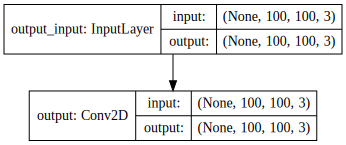

In [16]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
history = model.fit(in_train, out_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(in_valid, out_valid))

Train on 1224 samples, validate on 176 samples
Epoch 1/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0717 - PSNR: 13.2598 - val_loss: 0.0175 - val_PSNR: 18.0419
Epoch 2/2500
1224/1224 [==============================] - 9s 8ms/step - loss: 0.0147 - PSNR: 18.4979 - val_loss: 0.0116 - val_PSNR: 19.8394
Epoch 3/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0097 - PSNR: 20.2693 - val_loss: 0.0087 - val_PSNR: 21.1313
Epoch 4/2500
1224/1224 [==============================] - 9s 7ms/step - loss: 0.0072 - PSNR: 21.4947 - val_loss: 0.0069 - val_PSNR: 22.1031
Epoch 5/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0059 - PSNR: 22.3748 - val_loss: 0.0059 - val_PSNR: 22.8238
Epoch 6/2500
1224/1224 [==============================] - 11s 9ms/step - loss: 0.0051 - PSNR: 23.0412 - val_loss: 0.0051 - val_PSNR: 23.4100
Epoch 7/2500
1224/1224 [==============================] - 9s 7ms/step - loss: 0.0045 - PSNR: 23.6368 - val_lo

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.8760 - val_loss: 0.0017 - val_PSNR: 28.0353
Epoch 59/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.9138 - val_loss: 0.0017 - val_PSNR: 28.0473
Epoch 60/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.9077 - val_loss: 0.0017 - val_PSNR: 28.0591
Epoch 61/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.8909 - val_loss: 0.0017 - val_PSNR: 28.0703
Epoch 62/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.9446 - val_loss: 0.0017 - val_PSNR: 28.0815
Epoch 63/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.9004 - val_loss: 0.0017 - val_PSNR: 28.0922
Epoch 64/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0017 - PSNR: 27.9376 - val_loss: 0.0017 - val_PSNR: 28.1013
Epoch 65/2500
1224/1224 [==

1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2755 - val_loss: 0.0016 - val_PSNR: 28.3825
Epoch 117/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.2462 - val_loss: 0.0016 - val_PSNR: 28.3693
Epoch 118/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3434 - val_loss: 0.0016 - val_PSNR: 28.3888
Epoch 119/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2810 - val_loss: 0.0016 - val_PSNR: 28.3664
Epoch 120/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3206 - val_loss: 0.0016 - val_PSNR: 28.3856
Epoch 121/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3530 - val_loss: 0.0016 - val_PSNR: 28.3915
Epoch 122/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2550 - val_loss: 0.0016 - val_PSNR: 28.3817
Epoch 123/2500
1224/1

Epoch 174/2500
1224/1224 [==============================] - 8s 6ms/step - loss: 0.0016 - PSNR: 28.4309 - val_loss: 0.0016 - val_PSNR: 28.4220
Epoch 175/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3194 - val_loss: 0.0016 - val_PSNR: 28.4206
Epoch 176/2500
1224/1224 [==============================] - 8s 7ms/step - loss: 0.0016 - PSNR: 28.3273 - val_loss: 0.0016 - val_PSNR: 28.4084
Epoch 177/2500
1224/1224 [==============================] - 8s 7ms/step - loss: 0.0016 - PSNR: 28.3393 - val_loss: 0.0016 - val_PSNR: 28.4193
Epoch 178/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3924 - val_loss: 0.0016 - val_PSNR: 28.4214
Epoch 179/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3359 - val_loss: 0.0016 - val_PSNR: 28.4208
Epoch 180/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3101 - val_loss: 0.0016 - val_PSNR: 28.4223
Epoch 

1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4123 - val_loss: 0.0016 - val_PSNR: 28.4355
Epoch 232/2500
1224/1224 [==============================] - 9s 7ms/step - loss: 0.0016 - PSNR: 28.3554 - val_loss: 0.0016 - val_PSNR: 28.4234
Epoch 233/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3637 - val_loss: 0.0016 - val_PSNR: 28.4269
Epoch 234/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0016 - PSNR: 28.3331 - val_loss: 0.0016 - val_PSNR: 28.4365
Epoch 235/2500
1224/1224 [==============================] - 12s 10ms/step - loss: 0.0016 - PSNR: 28.3645 - val_loss: 0.0016 - val_PSNR: 28.4306
Epoch 236/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0016 - PSNR: 28.3384 - val_loss: 0.0016 - val_PSNR: 28.4292
Epoch 237/2500
1224/1224 [==============================] - 9s 8ms/step - loss: 0.0016 - PSNR: 28.3832 - val_loss: 0.0016 - val_PSNR: 28.4349
Epoch 238/2500
12

1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3680 - val_loss: 0.0016 - val_PSNR: 28.4341
Epoch 289/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.2960 - val_loss: 0.0016 - val_PSNR: 28.4337
Epoch 290/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3491 - val_loss: 0.0016 - val_PSNR: 28.4366
Epoch 291/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3445 - val_loss: 0.0016 - val_PSNR: 28.4435
Epoch 292/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3092 - val_loss: 0.0016 - val_PSNR: 28.4331
Epoch 293/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3752 - val_loss: 0.0016 - val_PSNR: 28.4394
Epoch 294/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0016 - PSNR: 28.3783 - val_loss: 0.0016 - val_PSNR: 28.4348
Epoch 295/2500
1224/

1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3664 - val_loss: 0.0016 - val_PSNR: 28.4374
Epoch 346/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3248 - val_loss: 0.0016 - val_PSNR: 28.4472
Epoch 347/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3110 - val_loss: 0.0016 - val_PSNR: 28.4405
Epoch 348/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.2923 - val_loss: 0.0016 - val_PSNR: 28.4351
Epoch 349/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2931 - val_loss: 0.0016 - val_PSNR: 28.4438
Epoch 350/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3877 - val_loss: 0.0016 - val_PSNR: 28.4455
Epoch 351/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3392 - val_loss: 0.0016 - val_PSNR: 28.4483
Epoch 352/2500
1224/1

Epoch 403/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3154 - val_loss: 0.0016 - val_PSNR: 28.4478
Epoch 404/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.2808 - val_loss: 0.0016 - val_PSNR: 28.4382
Epoch 405/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3684 - val_loss: 0.0016 - val_PSNR: 28.4434
Epoch 406/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3919 - val_loss: 0.0016 - val_PSNR: 28.4510
Epoch 407/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3533 - val_loss: 0.0016 - val_PSNR: 28.4422
Epoch 408/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3658 - val_loss: 0.0016 - val_PSNR: 28.4477
Epoch 409/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3476 - val_loss: 0.0016 - val_PSNR: 28.4324
Epoch 

Epoch 461/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3143 - val_loss: 0.0016 - val_PSNR: 28.4524
Epoch 462/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4225 - val_loss: 0.0016 - val_PSNR: 28.4478
Epoch 463/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2883 - val_loss: 0.0016 - val_PSNR: 28.4482
Epoch 464/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2948 - val_loss: 0.0016 - val_PSNR: 28.4254
Epoch 465/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3769 - val_loss: 0.0016 - val_PSNR: 28.4433
Epoch 466/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3942 - val_loss: 0.0016 - val_PSNR: 28.4429
Epoch 467/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3496 - val_loss: 0.0016 - val_PSNR: 28.4479
Epoch 

Epoch 519/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3854 - val_loss: 0.0016 - val_PSNR: 28.4511
Epoch 520/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3748 - val_loss: 0.0016 - val_PSNR: 28.4458
Epoch 521/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.4135 - val_loss: 0.0016 - val_PSNR: 28.4427
Epoch 522/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.4283 - val_loss: 0.0016 - val_PSNR: 28.4519 0.
Epoch 523/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3076 - val_loss: 0.0016 - val_PSNR: 28.4487
Epoch 524/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3469 - val_loss: 0.0016 - val_PSNR: 28.4480
Epoch 525/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3323 - val_loss: 0.0016 - val_PSNR: 28.4513
Epo

1224/1224 [==============================] - 8s 6ms/step - loss: 0.0016 - PSNR: 28.3526 - val_loss: 0.0016 - val_PSNR: 28.4459
Epoch 577/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3313 - val_loss: 0.0016 - val_PSNR: 28.4473
Epoch 578/2500
1224/1224 [==============================] - 8s 6ms/step - loss: 0.0016 - PSNR: 28.3026 - val_loss: 0.0016 - val_PSNR: 28.4510
Epoch 579/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3308 - val_loss: 0.0016 - val_PSNR: 28.4460
Epoch 580/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3582 - val_loss: 0.0016 - val_PSNR: 28.4422
Epoch 581/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3484 - val_loss: 0.0016 - val_PSNR: 28.4430
Epoch 582/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3556 - val_loss: 0.0016 - val_PSNR: 28.4365
Epoch 583/2500
1224/1

Epoch 634/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2817 - val_loss: 0.0016 - val_PSNR: 28.4543
Epoch 635/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3526 - val_loss: 0.0016 - val_PSNR: 28.4504
Epoch 636/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3854 - val_loss: 0.0016 - val_PSNR: 28.4521
Epoch 637/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3625 - val_loss: 0.0016 - val_PSNR: 28.4536
Epoch 638/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3531 - val_loss: 0.0016 - val_PSNR: 28.4514
Epoch 639/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3692 - val_loss: 0.0016 - val_PSNR: 28.4495
Epoch 640/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3784 - val_loss: 0.0016 - val_PSNR: 28.4533
Epoch 

Epoch 692/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3386 - val_loss: 0.0016 - val_PSNR: 28.4484
Epoch 693/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4289 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 694/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3669 - val_loss: 0.0016 - val_PSNR: 28.4400
Epoch 695/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4077 - val_loss: 0.0016 - val_PSNR: 28.4430
Epoch 696/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3960 - val_loss: 0.0016 - val_PSNR: 28.4549
Epoch 697/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3419 - val_loss: 0.0016 - val_PSNR: 28.4528
Epoch 698/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3368 - val_loss: 0.0016 - val_PSNR: 28.4431
Epoch 

Epoch 750/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3482 - val_loss: 0.0016 - val_PSNR: 28.4504
Epoch 751/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3873 - val_loss: 0.0016 - val_PSNR: 28.4431
Epoch 752/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3111 - val_loss: 0.0016 - val_PSNR: 28.4554
Epoch 753/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3575 - val_loss: 0.0016 - val_PSNR: 28.4496
Epoch 754/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3737 - val_loss: 0.0016 - val_PSNR: 28.4489
Epoch 755/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3214 - val_loss: 0.0016 - val_PSNR: 28.4543
Epoch 756/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3101 - val_loss: 0.0016 - val_PSNR: 28.4529
Epoch 

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4492 - val_loss: 0.0016 - val_PSNR: 28.4559
Epoch 808/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3556 - val_loss: 0.0016 - val_PSNR: 28.4513
Epoch 809/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3762 - val_loss: 0.0016 - val_PSNR: 28.4503
Epoch 810/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3401 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 811/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3642 - val_loss: 0.0016 - val_PSNR: 28.4559
Epoch 812/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3372 - val_loss: 0.0016 - val_PSNR: 28.4540
Epoch 813/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3815 - val_loss: 0.0016 - val_PSNR: 28.4461
Epoch 814/2500
1224/1

Epoch 865/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3836 - val_loss: 0.0016 - val_PSNR: 28.4524
Epoch 866/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3852 - val_loss: 0.0016 - val_PSNR: 28.4546
Epoch 867/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3734 - val_loss: 0.0016 - val_PSNR: 28.4537
Epoch 868/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3449 - val_loss: 0.0016 - val_PSNR: 28.4537
Epoch 869/2500
1224/1224 [==============================] - 8s 6ms/step - loss: 0.0016 - PSNR: 28.4616 - val_loss: 0.0016 - val_PSNR: 28.4477
Epoch 870/2500
1224/1224 [==============================] - 9s 7ms/step - loss: 0.0016 - PSNR: 28.4378 - val_loss: 0.0016 - val_PSNR: 28.4371
Epoch 871/2500
1224/1224 [==============================] - 8s 7ms/step - loss: 0.0016 - PSNR: 28.4056 - val_loss: 0.0016 - val_PSNR: 28.4552
Epoch 

Epoch 923/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3952 - val_loss: 0.0016 - val_PSNR: 28.4512
Epoch 924/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3562 - val_loss: 0.0016 - val_PSNR: 28.4552
Epoch 925/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3716 - val_loss: 0.0016 - val_PSNR: 28.4519
Epoch 926/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3967 - val_loss: 0.0016 - val_PSNR: 28.4499
Epoch 927/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3404 - val_loss: 0.0016 - val_PSNR: 28.4477
Epoch 928/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3728 - val_loss: 0.0016 - val_PSNR: 28.4517
Epoch 929/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3304 - val_loss: 0.0016 - val_PSNR: 28.4354
Epoch 

Epoch 981/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4252 - val_loss: 0.0016 - val_PSNR: 28.4525
Epoch 982/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.2986 - val_loss: 0.0016 - val_PSNR: 28.4557
Epoch 983/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3881 - val_loss: 0.0016 - val_PSNR: 28.4364
Epoch 984/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3704 - val_loss: 0.0016 - val_PSNR: 28.4493
Epoch 985/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3958 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 986/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3766 - val_loss: 0.0016 - val_PSNR: 28.4534
Epoch 987/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3789 - val_loss: 0.0016 - val_PSNR: 28.4557
Epoch 

1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.2916 - val_loss: 0.0016 - val_PSNR: 28.4485
Epoch 1039/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4178 - val_loss: 0.0016 - val_PSNR: 28.4371
Epoch 1040/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4140 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 1041/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3896 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 1042/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.4439 - val_loss: 0.0016 - val_PSNR: 28.4503
Epoch 1043/2500
1224/1224 [==============================] - 7s 5ms/step - loss: 0.0016 - PSNR: 28.3465 - val_loss: 0.0016 - val_PSNR: 28.4534
Epoch 1044/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3627 - val_loss: 0.0016 - val_PSNR: 28.4437
Epoch 1045/2500

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4149 - val_loss: 0.0016 - val_PSNR: 28.4511
Epoch 1096/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3592 - val_loss: 0.0016 - val_PSNR: 28.4500
Epoch 1097/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4443 - val_loss: 0.0016 - val_PSNR: 28.4555
Epoch 1098/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3541 - val_loss: 0.0016 - val_PSNR: 28.4476
Epoch 1099/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3597 - val_loss: 0.0016 - val_PSNR: 28.4532
Epoch 1100/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3209 - val_loss: 0.0016 - val_PSNR: 28.4022
Epoch 1101/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3780 - val_loss: 0.0016 - val_PSNR: 28.4538
Epoch 1102/2500

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3611 - val_loss: 0.0016 - val_PSNR: 28.4550
Epoch 1153/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3280 - val_loss: 0.0016 - val_PSNR: 28.4534
Epoch 1154/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3555 - val_loss: 0.0016 - val_PSNR: 28.4189
Epoch 1155/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3808 - val_loss: 0.0016 - val_PSNR: 28.4455
Epoch 1156/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3095 - val_loss: 0.0016 - val_PSNR: 28.4412
Epoch 1157/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4013 - val_loss: 0.0016 - val_PSNR: 28.4489
Epoch 1158/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3317 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 1159/2500

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3397 - val_loss: 0.0016 - val_PSNR: 28.4564
Epoch 1210/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3270 - val_loss: 0.0016 - val_PSNR: 28.4496
Epoch 1211/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3581 - val_loss: 0.0016 - val_PSNR: 28.4559
Epoch 1212/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3183 - val_loss: 0.0016 - val_PSNR: 28.4533
Epoch 1213/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3036 - val_loss: 0.0016 - val_PSNR: 28.4545
Epoch 1214/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3217 - val_loss: 0.0016 - val_PSNR: 28.4530
Epoch 1215/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3668 - val_loss: 0.0016 - val_PSNR: 28.4476
Epoch 1216/2500

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3572 - val_loss: 0.0016 - val_PSNR: 28.4581
Epoch 1267/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3140 - val_loss: 0.0016 - val_PSNR: 28.4418
Epoch 1268/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4174 - val_loss: 0.0016 - val_PSNR: 28.4514
Epoch 1269/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3357 - val_loss: 0.0016 - val_PSNR: 28.4574
Epoch 1270/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3244 - val_loss: 0.0016 - val_PSNR: 28.4515
Epoch 1271/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3731 - val_loss: 0.0016 - val_PSNR: 28.4515
Epoch 1272/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3204 - val_loss: 0.0016 - val_PSNR: 28.4474
Epoch 1273/2500

1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4252 - val_loss: 0.0016 - val_PSNR: 28.4515
Epoch 1324/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3284 - val_loss: 0.0016 - val_PSNR: 28.4561
Epoch 1325/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3028 - val_loss: 0.0016 - val_PSNR: 28.4531
Epoch 1326/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3692 - val_loss: 0.0016 - val_PSNR: 28.4560
Epoch 1327/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.4268 - val_loss: 0.0016 - val_PSNR: 28.4556
Epoch 1328/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3473 - val_loss: 0.0016 - val_PSNR: 28.4423
Epoch 1329/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0016 - PSNR: 28.3077 - val_loss: 0.0016 - val_PSNR: 28.4542
Epoch 1330/2500

1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3430 - val_loss: 0.0016 - val_PSNR: 28.4345
Epoch 1381/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3479 - val_loss: 0.0016 - val_PSNR: 28.4454
Epoch 1382/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3504 - val_loss: 0.0016 - val_PSNR: 28.4525
Epoch 1383/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3577 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 1384/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3553 - val_loss: 0.0016 - val_PSNR: 28.4561
Epoch 1385/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3821 - val_loss: 0.0016 - val_PSNR: 28.4456
Epoch 1386/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3978 - val_loss: 0.0016 - val_PSNR: 28.4495
Epoch 1387/2500

1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3327 - val_loss: 0.0016 - val_PSNR: 28.4544
Epoch 1438/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3888 - val_loss: 0.0016 - val_PSNR: 28.4459
Epoch 1439/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.2962 - val_loss: 0.0016 - val_PSNR: 28.4571
Epoch 1440/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3539 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 1441/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3717 - val_loss: 0.0016 - val_PSNR: 28.4428
Epoch 1442/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3703 - val_loss: 0.0016 - val_PSNR: 28.4552
Epoch 1443/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.3762 - val_loss: 0.0016 - val_PSNR: 28.4397
Epoch 1444/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3648 - val_loss: 0.0016 - val_PSNR: 28.4526
Epoch 1495/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3470 - val_loss: 0.0016 - val_PSNR: 28.4549
Epoch 1496/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3674 - val_loss: 0.0016 - val_PSNR: 28.4531
Epoch 1497/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4562 - val_loss: 0.0016 - val_PSNR: 28.4525
Epoch 1498/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3149 - val_loss: 0.0016 - val_PSNR: 28.4563
Epoch 1499/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3488 - val_loss: 0.0016 - val_PSNR: 28.4485
Epoch 1500/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3537 - val_loss: 0.0016 - val_PSNR: 28.4490
Epoch 1501/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3836 - val_loss: 0.0016 - val_PSNR: 28.4573
Epoch 1552/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3539 - val_loss: 0.0016 - val_PSNR: 28.4540
Epoch 1553/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3672 - val_loss: 0.0016 - val_PSNR: 28.4551
Epoch 1554/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3594 - val_loss: 0.0016 - val_PSNR: 28.4522
Epoch 1555/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4226 - val_loss: 0.0016 - val_PSNR: 28.4507
Epoch 1556/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3608 - val_loss: 0.0016 - val_PSNR: 28.4441
Epoch 1557/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3659 - val_loss: 0.0016 - val_PSNR: 28.4463
Epoch 1558/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3543 - val_loss: 0.0016 - val_PSNR: 28.4520
Epoch 1609/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3441 - val_loss: 0.0016 - val_PSNR: 28.4569
Epoch 1610/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3847 - val_loss: 0.0016 - val_PSNR: 28.4555
Epoch 1611/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3238 - val_loss: 0.0016 - val_PSNR: 28.4545
Epoch 1612/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4765 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 1613/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3368 - val_loss: 0.0016 - val_PSNR: 28.4502
Epoch 1614/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4079 - val_loss: 0.0016 - val_PSNR: 28.4575
Epoch 1615/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3120 - val_loss: 0.0016 - val_PSNR: 28.4537
Epoch 1666/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3857 - val_loss: 0.0016 - val_PSNR: 28.4506
Epoch 1667/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0016 - PSNR: 28.2691 - val_loss: 0.0016 - val_PSNR: 28.4562
Epoch 1668/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3369 - val_loss: 0.0016 - val_PSNR: 28.4506
Epoch 1669/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3539 - val_loss: 0.0016 - val_PSNR: 28.4466
Epoch 1670/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3012 - val_loss: 0.0016 - val_PSNR: 28.4446
Epoch 1671/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3639 - val_loss: 0.0016 - val_PSNR: 28.4467
Epoch 1672/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3421 - val_loss: 0.0016 - val_PSNR: 28.4424
Epoch 1723/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3177 - val_loss: 0.0016 - val_PSNR: 28.4532
Epoch 1724/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4034 - val_loss: 0.0016 - val_PSNR: 28.4495
Epoch 1725/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3806 - val_loss: 0.0016 - val_PSNR: 28.4563
Epoch 1726/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3234 - val_loss: 0.0016 - val_PSNR: 28.4483
Epoch 1727/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3654 - val_loss: 0.0016 - val_PSNR: 28.4572
Epoch 1728/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3102 - val_loss: 0.0016 - val_PSNR: 28.4512
Epoch 1729/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3729 - val_loss: 0.0016 - val_PSNR: 28.4520
Epoch 1780/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3641 - val_loss: 0.0016 - val_PSNR: 28.3901
Epoch 1781/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3638 - val_loss: 0.0016 - val_PSNR: 28.4526
Epoch 1782/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3685 - val_loss: 0.0016 - val_PSNR: 28.4530
Epoch 1783/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3487 - val_loss: 0.0016 - val_PSNR: 28.4544
Epoch 1784/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4173 - val_loss: 0.0016 - val_PSNR: 28.4563
Epoch 1785/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3734 - val_loss: 0.0016 - val_PSNR: 28.4542
Epoch 1786/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3350 - val_loss: 0.0016 - val_PSNR: 28.4561
Epoch 1837/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4041 - val_loss: 0.0016 - val_PSNR: 28.4564
Epoch 1838/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3478 - val_loss: 0.0016 - val_PSNR: 28.4536
Epoch 1839/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3467 - val_loss: 0.0016 - val_PSNR: 28.4563
Epoch 1840/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3839 - val_loss: 0.0016 - val_PSNR: 28.4520
Epoch 1841/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3766 - val_loss: 0.0016 - val_PSNR: 28.4550
Epoch 1842/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4425 - val_loss: 0.0016 - val_PSNR: 28.4536
Epoch 1843/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4493 - val_loss: 0.0016 - val_PSNR: 28.4574
Epoch 1894/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3114 - val_loss: 0.0016 - val_PSNR: 28.4551
Epoch 1895/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3609 - val_loss: 0.0016 - val_PSNR: 28.4549
Epoch 1896/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3580 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 1897/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3685 - val_loss: 0.0016 - val_PSNR: 28.4304
Epoch 1898/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3967 - val_loss: 0.0016 - val_PSNR: 28.4538
Epoch 1899/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3851 - val_loss: 0.0016 - val_PSNR: 28.4520
Epoch 1900/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3548 - val_loss: 0.0016 - val_PSNR: 28.4568
Epoch 1951/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4074 - val_loss: 0.0016 - val_PSNR: 28.4471
Epoch 1952/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3671 - val_loss: 0.0016 - val_PSNR: 28.4553
Epoch 1953/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3777 - val_loss: 0.0016 - val_PSNR: 28.4511
Epoch 1954/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3616 - val_loss: 0.0016 - val_PSNR: 28.4567
Epoch 1955/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3439 - val_loss: 0.0016 - val_PSNR: 28.4534
Epoch 1956/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3851 - val_loss: 0.0016 - val_PSNR: 28.4570
Epoch 1957/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3912 - val_loss: 0.0016 - val_PSNR: 28.4540
Epoch 2008/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4056 - val_loss: 0.0016 - val_PSNR: 28.4551
Epoch 2009/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3633 - val_loss: 0.0016 - val_PSNR: 28.4547
Epoch 2010/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3101 - val_loss: 0.0016 - val_PSNR: 28.4502
Epoch 2011/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3362 - val_loss: 0.0016 - val_PSNR: 28.4177
Epoch 2012/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3697 - val_loss: 0.0016 - val_PSNR: 28.4371
Epoch 2013/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3378 - val_loss: 0.0016 - val_PSNR: 28.4554
Epoch 2014/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3556 - val_loss: 0.0016 - val_PSNR: 28.4489
Epoch 2065/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3717 - val_loss: 0.0016 - val_PSNR: 28.4523
Epoch 2066/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3939 - val_loss: 0.0016 - val_PSNR: 28.4542
Epoch 2067/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3311 - val_loss: 0.0016 - val_PSNR: 28.4531
Epoch 2068/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3166 - val_loss: 0.0016 - val_PSNR: 28.4449
Epoch 2069/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3377 - val_loss: 0.0016 - val_PSNR: 28.4504
Epoch 2070/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4042 - val_loss: 0.0016 - val_PSNR: 28.4557
Epoch 2071/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.2973 - val_loss: 0.0016 - val_PSNR: 28.4512
Epoch 2122/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3706 - val_loss: 0.0016 - val_PSNR: 28.4292
Epoch 2123/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.2896 - val_loss: 0.0016 - val_PSNR: 28.4395
Epoch 2124/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4171 - val_loss: 0.0016 - val_PSNR: 28.4495
Epoch 2125/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3566 - val_loss: 0.0016 - val_PSNR: 28.4522
Epoch 2126/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4493 - val_loss: 0.0016 - val_PSNR: 28.4567
Epoch 2127/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3136 - val_loss: 0.0016 - val_PSNR: 28.4569
Epoch 2128/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3043 - val_loss: 0.0016 - val_PSNR: 28.4240
Epoch 2179/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3816 - val_loss: 0.0016 - val_PSNR: 28.4411
Epoch 2180/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3711 - val_loss: 0.0016 - val_PSNR: 28.4536
Epoch 2181/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3598 - val_loss: 0.0016 - val_PSNR: 28.4376
Epoch 2182/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3993 - val_loss: 0.0016 - val_PSNR: 28.4556
Epoch 2183/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3599 - val_loss: 0.0016 - val_PSNR: 28.4492
Epoch 2184/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4092 - val_loss: 0.0016 - val_PSNR: 28.4581
Epoch 2185/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3771 - val_loss: 0.0016 - val_PSNR: 28.4574
Epoch 2236/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3863 - val_loss: 0.0016 - val_PSNR: 28.4564
Epoch 2237/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3554 - val_loss: 0.0016 - val_PSNR: 28.4532
Epoch 2238/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3814 - val_loss: 0.0016 - val_PSNR: 28.4544
Epoch 2239/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3735 - val_loss: 0.0016 - val_PSNR: 28.4566
Epoch 2240/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4114 - val_loss: 0.0016 - val_PSNR: 28.4558
Epoch 2241/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3444 - val_loss: 0.0016 - val_PSNR: 28.4547
Epoch 2242/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4005 - val_loss: 0.0016 - val_PSNR: 28.4564
Epoch 2293/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3321 - val_loss: 0.0016 - val_PSNR: 28.4576
Epoch 2294/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3527 - val_loss: 0.0016 - val_PSNR: 28.4539
Epoch 2295/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3505 - val_loss: 0.0016 - val_PSNR: 28.4524
Epoch 2296/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3880 - val_loss: 0.0016 - val_PSNR: 28.4575
Epoch 2297/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3538 - val_loss: 0.0016 - val_PSNR: 28.4577
Epoch 2298/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3397 - val_loss: 0.0016 - val_PSNR: 28.4574
Epoch 2299/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3366 - val_loss: 0.0016 - val_PSNR: 28.4545
Epoch 2350/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3830 - val_loss: 0.0016 - val_PSNR: 28.4513
Epoch 2351/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3401 - val_loss: 0.0016 - val_PSNR: 28.4504
Epoch 2352/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3263 - val_loss: 0.0016 - val_PSNR: 28.4570
Epoch 2353/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3939 - val_loss: 0.0016 - val_PSNR: 28.4530
Epoch 2354/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3763 - val_loss: 0.0016 - val_PSNR: 28.4566
Epoch 2355/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3751 - val_loss: 0.0016 - val_PSNR: 28.4498
Epoch 2356/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3662 - val_loss: 0.0016 - val_PSNR: 28.4055
Epoch 2407/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3474 - val_loss: 0.0016 - val_PSNR: 28.4507
Epoch 2408/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3387 - val_loss: 0.0016 - val_PSNR: 28.4574
Epoch 2409/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3289 - val_loss: 0.0016 - val_PSNR: 28.4550
Epoch 2410/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4097 - val_loss: 0.0016 - val_PSNR: 28.4557
Epoch 2411/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3844 - val_loss: 0.0016 - val_PSNR: 28.4525
Epoch 2412/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3737 - val_loss: 0.0016 - val_PSNR: 28.4541
Epoch 2413/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3481 - val_loss: 0.0016 - val_PSNR: 28.4576
Epoch 2464/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3306 - val_loss: 0.0016 - val_PSNR: 28.4548
Epoch 2465/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.4377 - val_loss: 0.0016 - val_PSNR: 28.4468
Epoch 2466/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3589 - val_loss: 0.0016 - val_PSNR: 28.4517
Epoch 2467/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3237 - val_loss: 0.0016 - val_PSNR: 28.4544
Epoch 2468/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.2889 - val_loss: 0.0016 - val_PSNR: 28.4506
Epoch 2469/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0016 - PSNR: 28.3845 - val_loss: 0.0016 - val_PSNR: 28.4535
Epoch 2470/2500

In [18]:
score = model.evaluate(in_valid, out_valid, batch_size=batch_size)
print(score)

176/176 [==============================] - 0s 1ms/step
[0.0015833890065550804, 28.455923405560579]


In [19]:
score = model.evaluate(in_test, out_test, batch_size=batch_size)
print(score)

1260/1260 [==============================] - 3s 2ms/step
[0.002473228620753313, 26.25098060426258]


In [20]:
model.save('model 1-3 color/model 1-3 color.h5')
json_string = model.to_json()  
open('model 1-3 color/model 1-3 color.json','w').write(json_string)

740

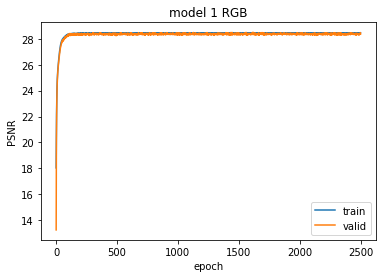

In [71]:
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['val_PSNR'])
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['PSNR'])
plt.title('model 1 RGB')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.savefig("model 1-3 color/PSNR model 1-3 color.png")
plt.show()

In [22]:
layer = model.layers[0]
weights = layer.get_weights()
w = weights[0]
filter1 = Image.new(mode, (w.shape[0],w.shape[1]))
filter2 = Image.new(mode, (w.shape[0],w.shape[1]))
filter3 = Image.new(mode, (w.shape[0],w.shape[1]))
w1 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w2 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w3 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
p1 = filter1.load()
p2 = filter2.load()
p3 = filter3.load()
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        helper1 = []
        helper2 = []
        helper3 = []
        for k in range(channels):
            helper1.append(int(w[i][j][k][0]*255))
            helper2.append(int(w[i][j][k][1]*255))
            helper3.append(int(w[i][j][k][2]*255))
            w1[k,i,j] = int(w[i][j][k][0]*255)
            w2[k,i,j] = int(w[i][j][k][1]*255)
            w3[k,i,j] = int(w[i][j][k][2]*255)
        p1[i,j] = tuple(helper1)
        p2[i,j] = tuple(helper2)
        p3[i,j] = tuple(helper3)
filter1.save('model 1-3 color/filter1.png')
filter2.save('model 1-3 color/filter2.png')
filter3.save('model 1-3 color/filter3.png')

In [23]:
w1.shape

(3, 3, 3)

In [24]:
filter1.show()

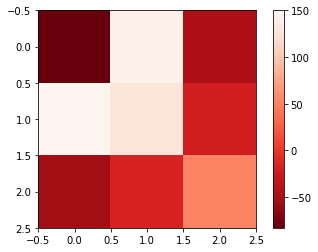

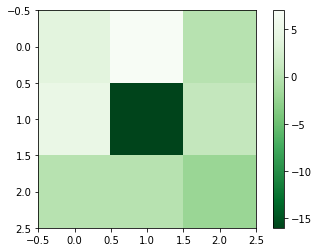

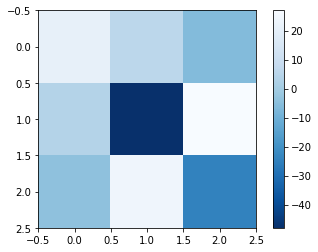

In [73]:
plt.imshow(w1[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt1 reds.png")
plt.show()

plt.imshow(w1[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt1 greens.png")
plt.show()

plt.imshow(w1[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt1 blues.png")
plt.show()

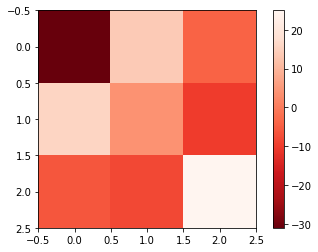

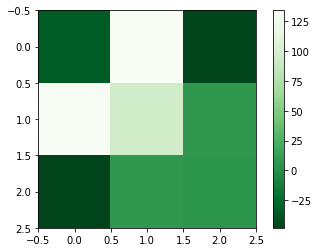

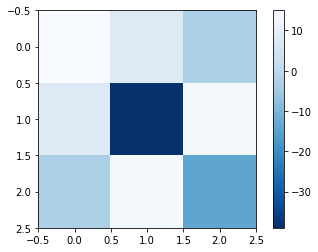

In [74]:
plt.imshow(w2[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt2 reds.png")
plt.show()

plt.imshow(w2[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt2 greens.png")
plt.show()

plt.imshow(w2[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt2 blues.png")
plt.show()

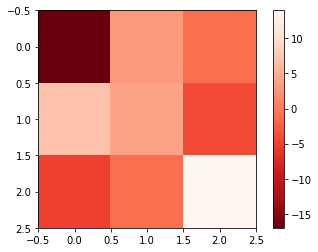

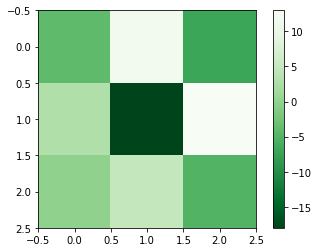

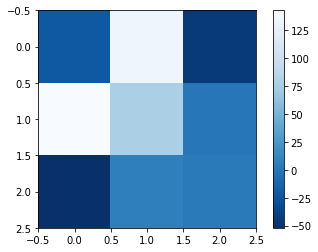

In [75]:
plt.imshow(w3[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt3 reds.png")
plt.show()

plt.imshow(w3[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt3 greens.png")
plt.show()

plt.imshow(w3[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 1-3 color/filterplt3 blues.png")
plt.show()

In [55]:
model = load_model('model 1-3 color/model 1-3 color.h5', custom_objects={'PSNR': PSNR}) #если нужно выкачать модель

In [56]:
prediction = model.predict(in_test)
prediction5 = model.predict(in_test5)
prediction14 = model.predict(in_test14)

In [45]:
threecompare(in_test[0], out_test[0], prediction[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.74

Bicubic with laplasian image
SSIM: 0.73

Produced image
SSIM: 0.77


In [46]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction, img_rows, img_cols, 'all/with bias')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5, img_rows, img_cols, 'set5/with bias')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14, img_rows, img_cols, 'set14/with bias')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.2078714506
Laplasian PSNR: 26.6480874616
Model PSNR: 28.095785639

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.0112492522
Laplasian PSNR: 30.2345389499
Model PSNR: 31.1192810736

Результаты для тестовой выборки Set14
Bicubic PSNR: 26.6066021658
Laplasian PSNR: 26.0811116748
Model PSNR: 27.6178065813


In [47]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.806364225132
Laplasian SSIM: 0.795693057826
Model SSIM: 0.846613014141

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.892216134629
Laplasian SSIM: 0.880425167524
Model SSIM: 0.920951092264

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.792792048263
Laplasian SSIM: 0.782297908131
Model SSIM: 0.834861038556


In [66]:
model1 = model

In [67]:
layer = model1.layers[0]
weights = layer.get_weights()
weights[1][0] = 0
layer.set_weights(weights)

In [68]:
prediction_1 = model1.predict(in_test)
prediction5_1 = model1.predict(in_test5)
prediction14_1 = model1.predict(in_test14)

In [39]:
threecompare(in_test[0], out_test[0], prediction_1[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.74

Bicubic with laplasian image
SSIM: 0.73

Produced image
SSIM: 0.77


In [40]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction_1, img_rows, img_cols, 'all/without bias')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5_1, img_rows, img_cols, 'set5/without bias')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14_1, img_rows, img_cols, 'set14/without bias')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.2078714506
Laplasian PSNR: 26.6480874616
Model PSNR: 28.0869182256

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.0112492522
Laplasian PSNR: 30.2345389499
Model PSNR: 31.1056153098

Результаты для тестовой выборки Set14
Bicubic PSNR: 26.6066021658
Laplasian PSNR: 26.0811116748
Model PSNR: 27.6096977306


In [41]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction_1, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5_1, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14_1, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.806364225132
Laplasian SSIM: 0.795693057826
Model SSIM: 0.84656443658

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.892216134629
Laplasian SSIM: 0.880425167524
Model SSIM: 0.920921365662

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.792792048263
Laplasian SSIM: 0.782297908131
Model SSIM: 0.834809480879
